# Imports and configs

In [1]:
!pip install scikit-learn==1.5.2 koolbox

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 13.3/13.3 MB 92.5 MB/s eta 0:00:00
  Attempting uninstall: scikit-learn
    Found existing installation: scikit-learn 1.2.2
    Uninstalling scikit-learn-1.2.2:
      Successfully uninstalled scikit-learn-1.2.2
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
cesium 0.12.4 requires numpy<3.0,>=2.0, but you have numpy 1.26.4 which is incompatible.


In [2]:
from sklearn.feature_selection import mutual_info_regression
from sklearn.ensemble import HistGradientBoostingClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import StratifiedKFold
from sklearn.metrics import accuracy_score
from catboost import CatBoostClassifier
from lightgbm import LGBMClassifier
from xgboost import XGBClassifier
from scipy.special import logit
from koolbox import Trainer
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
import numpy as np
import warnings
import shutil
import optuna
import json

warnings.filterwarnings('ignore')

In [3]:
class CFG:
    train_path = '/kaggle/input/playground-series-s5e7/train.csv'
    test_path = '/kaggle/input/playground-series-s5e7/test.csv'
    sample_sub_path = '/kaggle/input/playground-series-s5e7/sample_submission.csv'
    
    target = 'Personality'
    n_folds = 5
    seed = 42
    
    cv = StratifiedKFold(n_splits=n_folds, random_state=seed, shuffle=True)
    metric = accuracy_score
    
    n_optuna_trials = 500

# Data loading and preprocessing

In [4]:
train = pd.read_csv(CFG.train_path, index_col='id')
test = pd.read_csv(CFG.test_path, index_col='id')

train["Stage_fear"] = train["Stage_fear"].map({"No": 0, "Yes": 1})
train["Drained_after_socializing"] = train["Drained_after_socializing"].map({"No": 0, "Yes": 1})

test["Stage_fear"] = test["Stage_fear"].map({"No": 0, "Yes": 1})
test["Drained_after_socializing"] = test["Drained_after_socializing"].map({"No": 0, "Yes": 1})

train[CFG.target] = train[CFG.target].map({"Extrovert": 0, "Introvert": 1})

X = train.drop(CFG.target, axis=1)
y = train[CFG.target]
X_test = test

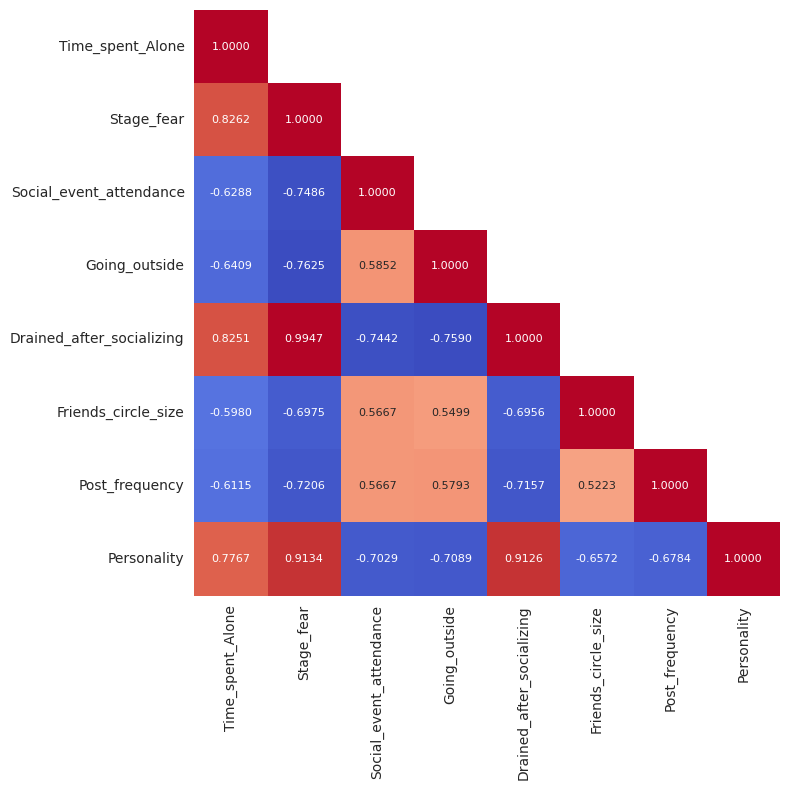

In [5]:
sns.set_style("white")
plt.figure(figsize=(8, 8))

corr_train = train.corr()
mask_train = np.triu(np.ones_like(corr_train, dtype=bool), k=1)

sns.heatmap(
    data=corr_train,
    annot=True,
    fmt='.4f',
    mask=mask_train,
    square=True,
    cmap='coolwarm',
    annot_kws={'size': 8},
    cbar=False
)

plt.tight_layout()
plt.show()

In [6]:
mutual_info = mutual_info_regression(X.fillna(0), y, random_state=CFG.seed)

mutual_info = pd.Series(mutual_info)
mutual_info.index = X.columns
mutual_info = pd.DataFrame(mutual_info.sort_values(ascending=False), columns=['Mutual Information'])
mutual_info.style.bar(subset=['Mutual Information'], cmap='RdYlGn')

,Mutual Information
Time_spent_Alone,0.353570
Drained_after_socializing,0.337575
Social_event_attendance,0.330482
Stage_fear,0.314673
Post_frequency,0.313469
Going_outside,0.304151
Friends_circle_size,0.288645


# Training base models

In [7]:
def save_submission(name, test_pred_probs, score, threshold=0.5):
    sub = pd.read_csv(CFG.sample_sub_path)
    sub[CFG.target] = (test_pred_probs > threshold).astype(int)
    sub[CFG.target] = sub[CFG.target].map({0: "Extrovert", 1: "Introvert"})
    sub.to_csv(f'sub_{name}_{score:.6f}.csv', index=False)
    return sub.head()

In [8]:
cb_params = {
    "border_count": 180,
    "colsample_bylevel": 0.7351678905666684,
    "depth": 7,
    "iterations": 2372,
    "l2_leaf_reg": 4.442847441200204,
    "learning_rate": 0.0514109059943355,
    "min_child_samples": 146,
    "random_state": 42,
    "random_strength": 0.18678416655567043,
    "subsample": 0.3511896501762123,
    "verbose": False
}

xgb_params = {
    "colsample_bylevel": 0.25155109886677396,
    "colsample_bynode": 0.5723191165109757,
    "colsample_bytree": 0.18034301813835885,
    "gamma": 3.6392698070258622,
    "max_depth": 16,
    "max_leaves": 67,
    "min_child_weight": 34,
    "n_estimators": 1853,
    "n_jobs": -1,
    "random_state": 42,
    "reg_alpha": 7.996080341061729,
    "reg_lambda": 46.83054555763492,
    "subsample": 0.9117754083869292
}

hgb_params = {
    'l2_regularization': 3.2797348813056515,
    'learning_rate': 0.04290001508632896,
    'max_depth': 292,
    'max_features': 0.9605841946578942,
    'max_iter': 2978,
    'max_leaf_nodes': 38,
    'min_samples_leaf': 254,
    'random_state': 42
}

lgbm_params = {
    "boosting_type": "gbdt",
    "colsample_bytree": 0.18283018243382332,
    "learning_rate": 0.09945326391012832,
    "max_bins": 36644,
    "min_child_samples": 105,
    "min_child_weight": 0.2083765599710974,
    "n_estimators": 244,
    "n_jobs": -1,
    "num_leaves": 122,
    "random_state": 42,
    "reg_alpha": 8.662578235164972,
    "reg_lambda": 3.5696291074963926,
    "subsample": 0.5360642841695424,
    "verbose": -1
}

lgbm_goss_params = {
    "boosting_type": "goss",
    "colsample_bytree": 0.11905309670044416,
    "learning_rate": 0.04641567005485582,
    "max_bins": 18501,
    "min_child_samples": 283,
    "min_child_weight": 0.5242575557671028,
    "n_estimators": 966,
    "n_jobs": -1,
    "num_leaves": 159,
    "random_state": 42,
    "reg_alpha": 8.160196501794122,
    "reg_lambda": 9.861767101758469,
    "subsample": 0.9259030065865966,
    "verbose": -1
}

lgbm_dart_params = {
    "boosting_type": "dart",
    "colsample_bytree": 0.1181378019860333,
    "learning_rate": 0.0910272033595692,
    "max_bins": 7386,
    "min_child_samples": 225,
    "min_child_weight": 0.28492487885169293,
    "n_estimators": 1454,
    "n_jobs": -1,
    "num_leaves": 163,
    "random_state": 42,
    "reg_alpha": 2.9686583338116925,
    "reg_lambda": 9.781841345026509,
    "subsample": 0.511061530253864,
    "verbose": -1
}

In [9]:
scores = {}
oof_pred_probs = {}
test_pred_probs = {}

## CatBoost

In [10]:
cb_trainer = Trainer(
    CatBoostClassifier(**cb_params),
    cv=CFG.cv,
    metric=CFG.metric,
    use_early_stopping=False,
    task="binary",
    metric_precision=6,
)

cb_trainer.fit(X, y)

scores["CatBoost"] = cb_trainer.fold_scores
oof_pred_probs["CatBoost"] = cb_trainer.oof_preds
test_pred_probs["CatBoost"] = cb_trainer.predict(X_test)

Training CatBoostClassifier

--- Fold 0 - accuracy_score: 0.966802 - Time: 11.08 s
--- Fold 1 - accuracy_score: 0.962753 - Time: 11.98 s
--- Fold 2 - accuracy_score: 0.963563 - Time: 11.13 s
--- Fold 3 - accuracy_score: 0.968691 - Time: 11.10 s
--- Fold 4 - accuracy_score: 0.967873 - Time: 12.04 s

------ Overall accuracy_score: 0.965936 - Mean accuracy_score: 0.965936 ± 0.002360 - Time: 58.03 s


## XGBoost

In [11]:
xgb_trainer = Trainer(
    XGBClassifier(**xgb_params),
    cv=CFG.cv,
    metric=CFG.metric,
    task="binary",
    metric_precision=6,
)

xgb_trainer.fit(X, y)

scores["XGBoost"] = xgb_trainer.fold_scores
oof_pred_probs["XGBoost"] = xgb_trainer.oof_preds
test_pred_probs["XGBoost"] = xgb_trainer.predict(X_test)

Training XGBClassifier

--- Fold 0 - accuracy_score: 0.969501 - Time: 0.85 s
--- Fold 1 - accuracy_score: 0.966802 - Time: 0.78 s
--- Fold 2 - accuracy_score: 0.965182 - Time: 0.79 s
--- Fold 3 - accuracy_score: 0.970580 - Time: 0.91 s
--- Fold 4 - accuracy_score: 0.971382 - Time: 0.80 s

------ Overall accuracy_score: 0.968689 - Mean accuracy_score: 0.968689 ± 0.002339 - Time: 4.84 s


## HistGradientBoostingClassifier

In [12]:
hgb_trainer = Trainer(
    HistGradientBoostingClassifier(**hgb_params),
    cv=CFG.cv,
    metric=CFG.metric,
    task="binary",
    metric_precision=6,
)

hgb_trainer.fit(X, y)

scores["HistGradientBoosting"] = hgb_trainer.fold_scores
oof_pred_probs["HistGradientBoosting"] = hgb_trainer.oof_preds
test_pred_probs["HistGradientBoosting"] = hgb_trainer.predict(X_test)

Training HistGradientBoostingClassifier

--- Fold 0 - accuracy_score: 0.969771 - Time: 0.36 s
--- Fold 1 - accuracy_score: 0.967072 - Time: 0.55 s
--- Fold 2 - accuracy_score: 0.965992 - Time: 0.46 s
--- Fold 3 - accuracy_score: 0.970040 - Time: 0.45 s
--- Fold 4 - accuracy_score: 0.970842 - Time: 0.44 s

------ Overall accuracy_score: 0.968743 - Mean accuracy_score: 0.968743 ± 0.001871 - Time: 2.98 s


## LightGBM (gbdt)

In [13]:
lgbm_gbdt_trainer = Trainer(
    LGBMClassifier(**lgbm_params),
    cv=CFG.cv,
    metric=CFG.metric,
    use_early_stopping=False,
    task="binary",
    metric_precision=6,
)

lgbm_gbdt_trainer.fit(X, y)

scores["LightGBM (gbdt)"] = lgbm_gbdt_trainer.fold_scores
oof_pred_probs["LightGBM (gbdt)"] = lgbm_gbdt_trainer.oof_preds
test_pred_probs["LightGBM (gbdt)"] = lgbm_gbdt_trainer.predict(X_test)

Training LGBMClassifier

--- Fold 0 - accuracy_score: 0.969231 - Time: 0.26 s
--- Fold 1 - accuracy_score: 0.967611 - Time: 0.16 s
--- Fold 2 - accuracy_score: 0.965722 - Time: 0.16 s
--- Fold 3 - accuracy_score: 0.970580 - Time: 0.14 s
--- Fold 4 - accuracy_score: 0.971652 - Time: 0.14 s

------ Overall accuracy_score: 0.968959 - Mean accuracy_score: 0.968959 ± 0.002110 - Time: 1.58 s


## LightGBM (goss)

In [14]:
lgbm_goss_trainer = Trainer(
    LGBMClassifier(**lgbm_goss_params),
    cv=CFG.cv,
    metric=CFG.metric,
    use_early_stopping=False,
    task="binary",
    metric_precision=6,
)

lgbm_goss_trainer.fit(X, y)

scores["LightGBM (goss)"] = lgbm_goss_trainer.fold_scores
oof_pred_probs["LightGBM (goss)"] = lgbm_goss_trainer.oof_preds
test_pred_probs["LightGBM (goss)"] = lgbm_goss_trainer.predict(X_test)

Training LGBMClassifier

--- Fold 0 - accuracy_score: 0.969501 - Time: 0.80 s
--- Fold 1 - accuracy_score: 0.967611 - Time: 0.81 s
--- Fold 2 - accuracy_score: 0.965722 - Time: 0.82 s
--- Fold 3 - accuracy_score: 0.970580 - Time: 0.94 s
--- Fold 4 - accuracy_score: 0.971112 - Time: 0.83 s

------ Overall accuracy_score: 0.968905 - Mean accuracy_score: 0.968905 ± 0.001992 - Time: 4.93 s


## LightGBM (dart)

In [15]:
lgbm_dart_trainer = Trainer(
    LGBMClassifier(**lgbm_dart_params),
    cv=CFG.cv,
    metric=CFG.metric,
    use_early_stopping=False,
    task="binary",
    metric_precision=6,
)

lgbm_dart_trainer.fit(X, y)

scores["LightGBM (dart)"] = lgbm_dart_trainer.fold_scores
oof_pred_probs["LightGBM (dart)"] = lgbm_dart_trainer.oof_preds
test_pred_probs["LightGBM (dart)"] = lgbm_dart_trainer.predict(X_test)

Training LGBMClassifier

--- Fold 0 - accuracy_score: 0.969501 - Time: 9.40 s
--- Fold 1 - accuracy_score: 0.967611 - Time: 10.46 s
--- Fold 2 - accuracy_score: 0.965452 - Time: 9.51 s
--- Fold 3 - accuracy_score: 0.970580 - Time: 9.06 s
--- Fold 4 - accuracy_score: 0.971112 - Time: 10.68 s

------ Overall accuracy_score: 0.968851 - Mean accuracy_score: 0.968851 ± 0.002079 - Time: 49.83 s


# Ensembling with Logistic Regression

In [16]:
def plot_weights(weights, title):
    sorted_indices = np.argsort(weights[0])[::-1]
    sorted_coeffs = np.array(weights[0])[sorted_indices]
    sorted_model_names = np.array(list(oof_pred_probs.keys()))[sorted_indices]

    plt.figure(figsize=(10, weights.shape[1] * 0.5))
    ax = sns.barplot(x=sorted_coeffs, y=sorted_model_names, palette="RdYlGn_r")

    for i, (value, name) in enumerate(zip(sorted_coeffs, sorted_model_names)):
        if value >= 0:
            ax.text(value, i, f'{value:.3f}', va='center', ha='left', color='black')
        else:
            ax.text(value, i, f'{value:.3f}', va='center', ha='right', color='black')

    xlim = ax.get_xlim()
    ax.set_xlim(xlim[0] - 0.1 * abs(xlim[0]), xlim[1] + 0.1 * abs(xlim[1]))

    plt.title(title)
    plt.xlabel('')
    plt.ylabel('')
    plt.tight_layout()
    plt.show()

In [17]:
X = logit(pd.DataFrame(oof_pred_probs).clip(1e-15, 1-1e-15))
X_test = logit(pd.DataFrame(test_pred_probs).clip(1e-15, 1-1e-15))

In [18]:
def objective(trial):
    solver_penalty_options = [
        ('liblinear', 'l1'),
        ('liblinear', 'l2'),
        ('lbfgs', 'l2'),
        ('lbfgs', None),
        ('newton-cg', 'l2'),
        ('newton-cg', None),
        ('newton-cholesky', 'l2'),
        ('newton-cholesky', None)
    ]
    solver, penalty = trial.suggest_categorical('solver_penalty', solver_penalty_options)
    
    params = {
        'random_state': CFG.seed,
        'max_iter': 500,
        'C': trial.suggest_float('C', 0, 10),
        'tol': trial.suggest_float('tol', 1e-10, 1e-1),
        'fit_intercept': trial.suggest_categorical('fit_intercept', [True, False]),
        'class_weight': trial.suggest_categorical('class_weight', ['balanced', None]),
        'solver': solver,
        'penalty': penalty
    }
    
    threshold = trial.suggest_float('threshold', 0, 1, step=0.001)
    
    trainer = Trainer(
        LogisticRegression(**params),
        cv=CFG.cv,
        metric=CFG.metric,
        metric_precision=6,
        metric_threshold=threshold,
        use_early_stopping=False,
        verbose=False,
        task="binary",
    )
    trainer.fit(X, y)
    
    return np.mean(trainer.fold_scores)

sampler = optuna.samplers.TPESampler(seed=CFG.seed, multivariate=True, n_startup_trials=CFG.n_optuna_trials // 10)
study = optuna.create_study(direction='maximize', sampler=sampler)
study.optimize(objective, n_trials=CFG.n_optuna_trials, n_jobs=-1)
best_params = study.best_params

[I 2025-07-01 08:36:42,897] A new study created in memory with name: no-name-19ef5398-251a-488d-b43f-575fb95b7a87
[I 2025-07-01 08:36:45,802] Trial 3 finished with value: 0.9690672519477795 and parameters: {'solver_penalty': ('newton-cholesky', 'l2'), 'C': 3.4599919976848206, 'tol': 0.03733137183466457, 'fit_intercept': True, 'class_weight': None, 'threshold': 0.521}. Best is trial 3 with value: 0.9690672519477795.
[I 2025-07-01 08:36:45,804] Trial 0 finished with value: 0.9536277664588452 and parameters: {'solver_penalty': ('newton-cholesky', None), 'C': 1.5822051874263876, 'tol': 0.04196616433276069, 'fit_intercept': True, 'class_weight': 'balanced', 'threshold': 0.153}. Best is trial 3 with value: 0.9690672519477795.
[I 2025-07-01 08:36:45,981] Trial 2 finished with value: 0.9685813928407996 and parameters: {'solver_penalty': ('newton-cg', 'l2'), 'C': 4.043995061254839, 'tol': 0.07322600218040272, 'fit_intercept': True, 'class_weight': None, 'threshold': 0.7010000000000001}. Best is

In [19]:
solver, penalty = best_params['solver_penalty']
lr_params = {
    'random_state': CFG.seed,
    'max_iter': 500,
    'C': best_params['C'],
    'tol': best_params['tol'],
    'fit_intercept': best_params['fit_intercept'],
    'class_weight': best_params['class_weight'],
    'solver': solver,
    'penalty': penalty
}

In [20]:
print(json.dumps(lr_params, indent=2))

{
  "random_state": 42,
  "max_iter": 500,
  "C": 5.678638296898917,
  "tol": 0.0930540486834568,
  "fit_intercept": false,
  "class_weight": "balanced",
  "solver": "newton-cholesky",
  "penalty": "l2"
}


In [21]:
best_threshold = study.best_params['threshold']
print(f'Best threshold: {best_threshold:.3f}')

Best threshold: 0.538


In [22]:
lr_trainer = Trainer(
    LogisticRegression(**lr_params),
    cv=CFG.cv,
    metric=CFG.metric,
    metric_threshold=best_threshold,
    metric_precision=6,
    use_early_stopping=False,
    task="binary",
)

lr_trainer.fit(X, y)

scores["LogisticRegression"] = lr_trainer.fold_scores
lr_test_pred_probs = lr_trainer.predict(X_test)

Training LogisticRegression

--- Fold 0 - accuracy_score: 0.970310 - Time: 0.02 s
--- Fold 1 - accuracy_score: 0.967881 - Time: 0.02 s
--- Fold 2 - accuracy_score: 0.965992 - Time: 0.02 s
--- Fold 3 - accuracy_score: 0.971120 - Time: 0.02 s
--- Fold 4 - accuracy_score: 0.971112 - Time: 0.02 s

------ Overall accuracy_score: 0.969283 - Mean accuracy_score: 0.969283 ± 0.002028 - Time: 0.81 s


In [23]:
save_submission('logistic-regression', lr_test_pred_probs, np.mean(scores['LogisticRegression']), best_threshold)

,id,Personality
0,18524,Extrovert
1,18525,Introvert
2,18526,Extrovert
3,18527,Extrovert
4,18528,Introvert


In [24]:
lr_coeffs = np.zeros((1,len(X.columns)))
for estimator in lr_trainer.estimators:
    lr_coeffs += estimator.coef_ / CFG.n_folds

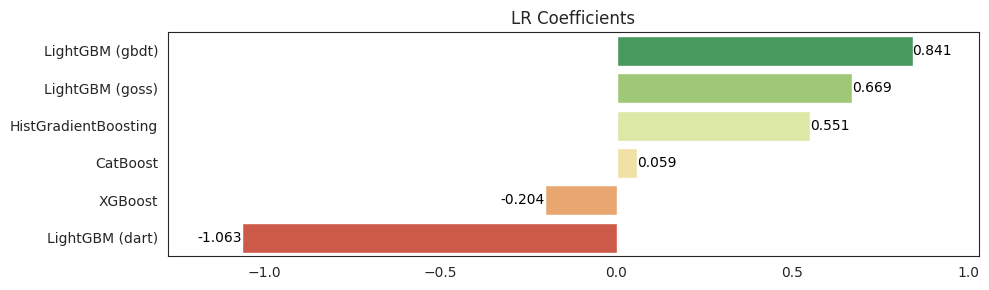

In [25]:
plot_weights(lr_coeffs, 'LR Coefficients')

# Results

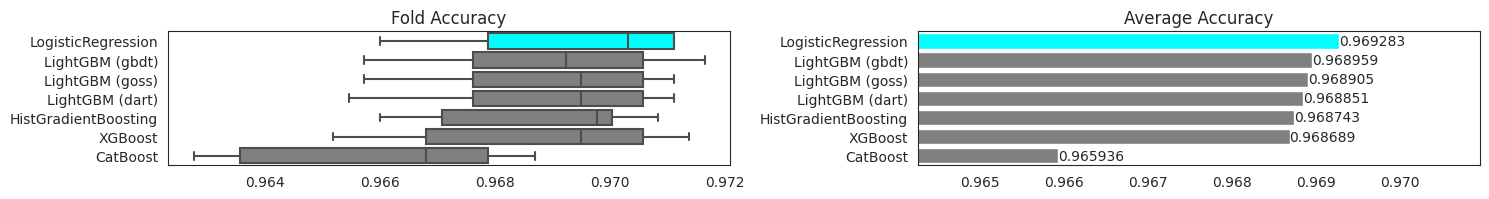

In [26]:
scores = pd.DataFrame(scores)
mean_scores = scores.mean().sort_values(ascending=False)
order = scores.mean().sort_values(ascending=False).index.tolist()

min_score = mean_scores.min()
max_score = mean_scores.max()
padding = (max_score - min_score) * 0.5
lower_limit = min_score - padding
upper_limit = max_score + padding

fig, axs = plt.subplots(1, 2, figsize=(15, scores.shape[1] * 0.3))

boxplot = sns.boxplot(data=scores, order=order, ax=axs[0], orient='h', color='grey')
axs[0].set_title('Fold Accuracy')
axs[0].set_xlabel('')
axs[0].set_ylabel('')

barplot = sns.barplot(x=mean_scores.values, y=mean_scores.index, ax=axs[1], color='grey')
axs[1].set_title('Average Accuracy')
axs[1].set_xlabel('')
axs[1].set_xlim(left=lower_limit, right=upper_limit)
axs[1].set_ylabel('')

for i, (score, model) in enumerate(zip(mean_scores.values, mean_scores.index)):
    color = 'cyan' if 'logistic' in model.lower() else 'grey'
    barplot.patches[i].set_facecolor(color)
    boxplot.patches[i].set_facecolor(color)
    barplot.text(score, i, round(score, 6), va='center')

plt.tight_layout()
plt.show()

In [27]:
shutil.rmtree('catboost_info', ignore_errors=True)